In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy as sp
import h5py

import matplotlib.lines as mlines
from functools import reduce

sys.path.append('../methods/')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Low-dim embedding 

In [2]:
path_base = '/home/jinandmaya/simu_poi/'
ind = '_d_2_r_1_noise_0.5'
n = 300
seed = 0
method = 'causarray_r_4'
path_data = path_base + 'data/simu_{}{}/'.format(n, ind)
path_result = path_base + 'results/simu_{}{}/'.format(n, ind)

filename = path_data+'simu_data_{}.h5'.format(seed)

with h5py.File(filename, 'r') as f:
    A = np.array(f['A'], dtype='float')
    W = np.array(f['W'], dtype='float')
    W = W[:, :-1]
    W[:,1:] = (W[:,1:] - np.mean(W[:,1:], axis=0, keepdims=True)) / np.std(W[:,1:], axis=0, ddof=1, keepdims=True)
    Y = np.array(f['Y'], dtype='float')
    Y = np.minimum(Y, np.quantile(np.max(Y, axis=0), 0.999))
    theta = np.array(f['theta'], dtype='float')

In [3]:
r = int(ind.split('_')[4])
d = int(ind.split('_')[2]) + r
noise = float(ind.split('_')[-1])

# n = 500 # number of cells
# d = 0 # number of covariates
p = 2000 # number of genes
s = 200 # number of signals    
signal = .5 # signal strength
# noise = .5 # noise level
psi = 0.1 # zero-inflation probability
n = 3000
seed = 0
from simu_poi_data import generate_data
W_all, A, Y, Y_sc, metadata, B, theta, signals = generate_data(
                n, p, d, r, s, m=10, intercept=1., signal=signal, noise=noise, psi=psi, seed=seed)
W = W_all[:, :-1]
W[:,1:] = (W[:,1:] - np.mean(W[:,1:], axis=0, keepdims=True)) / np.std(W[:,1:], axis=0, ddof=1, keepdims=True)                

In [4]:
from causarray import LFC, fit_gcate
from causarray.DR_estimation import fit_ps

res_gcate = fit_gcate(Y, np.c_[W,A], 4, offset=True)

'Estimating dispersion parameter...'
'Fitting poisson GLM with offset...'


100%|██████████| 2000/2000 [00:08<00:00, 229.63it/s]


'Estimating initial coefficients with GLMs...'
'Fitting nb GLM with offset...'


100%|██████████| 2000/2000 [00:00<00:00, 4082.00it/s]


'Fitting nb GLM with offset...'


  1%|          | 6/500 [00:19<26:25,  3.21s/it, Early stopped.Best Epoch: 0. Best Metric: 2.952344.]


In [5]:
d = W.shape[1]
a = 1
d,a

(3, 1)

In [6]:
W_new = np.c_[W, res_gcate[0][:,d+a:]]

offset = np.log(res_gcate[2]['kwargs_glm']['size_factor'])

libsize = np.log2(np.sum(Y, axis=1)); 
libsize = (libsize - np.mean(libsize)) / np.std(libsize, ddof=1)
W_A = np.c_[W_new, libsize]
res = LFC(
        Y=Y, W=W_new, A=A, W_A=W_A, fdx=True,
        glm_alpha=.1, shrinkage=True,
        alpha=0.1, c=0.1, family='nb', offset=offset, disp_glm=None, verbose=True
      )

'Estimating LFC...'
{'a': 1, 'd': 7, 'd_A': 8, 'estimands': 'LFC', 'n': 3000, 'p': 2000}
{'C': 1.0,
 'class_weight': 'balanced',
 'fit_intercept': False,
 'random_state': 0}
{'disp_glm': None,
 'offset': array([-2.40606832e-02, -6.94032936e-07, -5.13655851e-03, ...,
        8.12521105e-03, -1.02607437e-02, -5.43677347e-03]),
 'shrinkage': True}
'Estimating dispersion parameter...'
'Fitting poisson GLM with offset...'


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 3415.17it/s]


'Fitting nb GLM with offset...'


100%|██████████| 2000/2000 [00:05<00:00, 364.91it/s]


In [7]:
np.sum((res[0]['rej'].values>0.1)&(theta==0))/np.sum((res[0]['rej'].values>0.1)), np.sum((res[0]['rej'].values>0.1))

(0.05853658536585366, 205)

In [8]:
np.sum((res[0]['padj'].values<0.1)&(theta==0))/np.sum((res[0]['padj'].values<0.1)), np.sum((res[0]['padj'].values<0.1))

(0.10232558139534884, 215)

In [9]:
import scanpy as sc

adata = sc.AnnData(
    X= Y,
    obs = pd.DataFrame(
        data = np.c_[A.reshape(-1,1), W_all[:,-1:]],
        columns = ['A','Z']
    ),
)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.tl.pca(adata, n_comps=100)
sc.pp.neighbors(adata)
sc.tl.umap(adata, n_components=2)
adata_cf = sc.AnnData(
    X = res[1]['Y_hat_0'][:,:,0],
    obs = pd.DataFrame(
        data = np.c_[A.reshape(-1,1), W_all[:,-1:]],
        columns = ['A','Z']
    ),
)
sc.pp.log1p(adata_cf)

sc.tl.pca(adata_cf, n_comps=100)
sc.pp.neighbors(adata_cf)
sc.tl.umap(adata_cf, n_components=2)

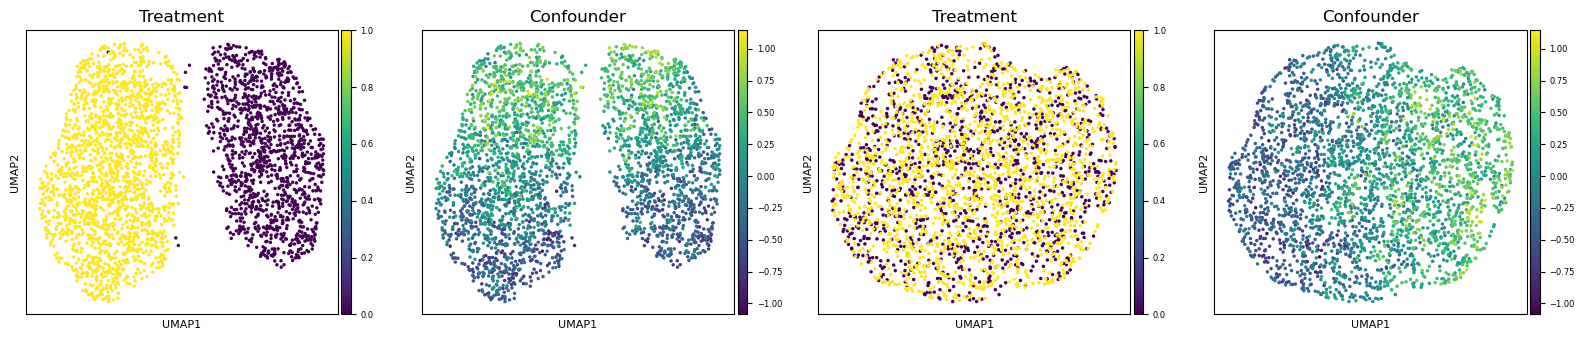

In [10]:

fig, axes = plt.subplots(1,4, figsize=(16,3.5))

axes[0] = sc.pl.umap(adata, color='A', s=25, ax=axes[0], show=False)
axes[2] = sc.pl.umap(adata_cf, color='A', s=25, ax=axes[2], show=False)

axes[1] = sc.pl.umap(adata, color='Z', s=25, ax=axes[1], show=False)
axes[3] = sc.pl.umap(adata_cf, color='Z', s=25, ax=axes[3], show=False)

for i in [0,2]:
    axes[i].set_title('Treatment')
    axes[i+1].set_title('Confounder')
# for j in range(2):
#     axes[1,j].set_title('')

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
    cbar.ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust the font size here
    cbar.ax.tick_params(axis='both', which='minor', labelsize=6)  # Adjust the font size for minor ticks if needed
fig.tight_layout()
plt.savefig('results/simu_poi_umap_AZ.pdf', dpi=300, bbox_inches='tight')


# Benchmarking with Poisson simulation

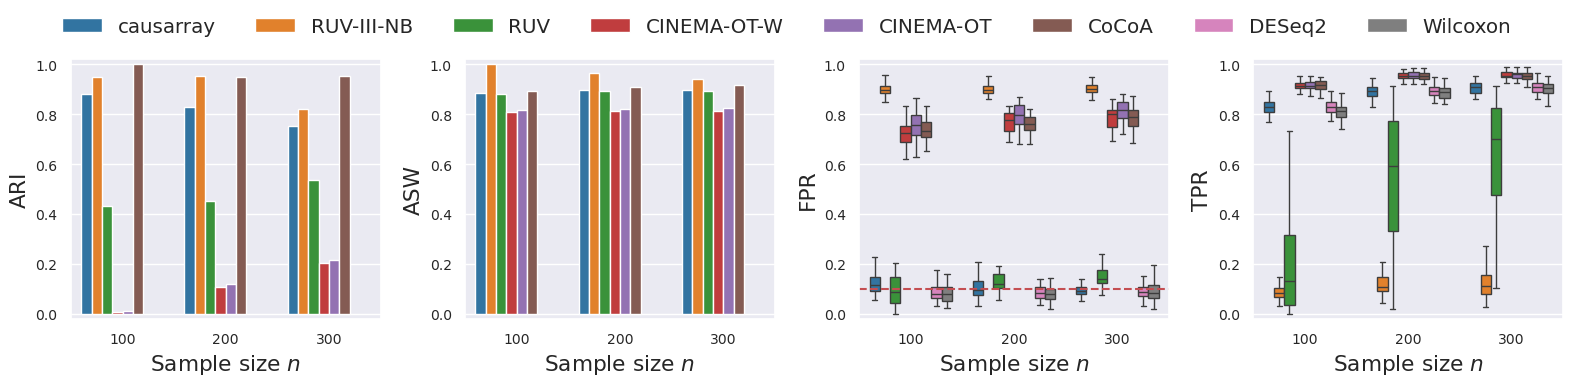

In [11]:
path_base = '/home/jinandmaya/simu_poi/'
ind = '_d_2_r_1_noise_0.5'

df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))

r_list = [4]
n_list = [100,200,300]

method_name = {'wilc':'Wilcoxon', 'DESeq':'DESeq2', 'cocoa':'CoCoA', 'cinemaot':'CINEMA-OT', 'cinemaotw':'CINEMA-OT-W',
    }
    
method_name.update(
    reduce(lambda a, b: dict(a, **b), 
    [{'ruv_r_{}'.format(r):'RUV' for r in r_list}, 
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB' for r in r_list}, 
      {'causarray_r_{}'.format(r):'causarray' for r in r_list} 
    ])
    )

df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]
df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)
df_test = df_test[df_test['n'].isin(n_list)]
df_cf = df_cf[df_cf['n'].isin(n_list)]

zmax = df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().max().values
zmin = 0.*df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().min().values
df_cf[['ARI', 'ASW']] = (df_cf[['ARI', 'ASW']].values - zmin[None,:])/(zmax[None,:]-zmin[None,:])

method_list = list(method_name.values())[::-1]
palette = sns.color_palette()[:len(method_list)]
hue_order = {i:c for i,c in zip(method_list, palette) }

sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,4), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):    
    sns.barplot(data=df_cf, x='n', y=metric, hue='method', hue_order=hue_order, 
        estimator='median', errorbar=None,
        ax=axes[j], palette=palette)#, showfliers=False)

axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]


for j in range(4):
    axes[j].set_ylim(-0.02,1.02)
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Sample size $n$')
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig(path_base + 'results/simu_poi{}.pdf'.format(ind), bbox_inches='tight', pad_inches=0, dpi=300)

# Sensitivity in $r$

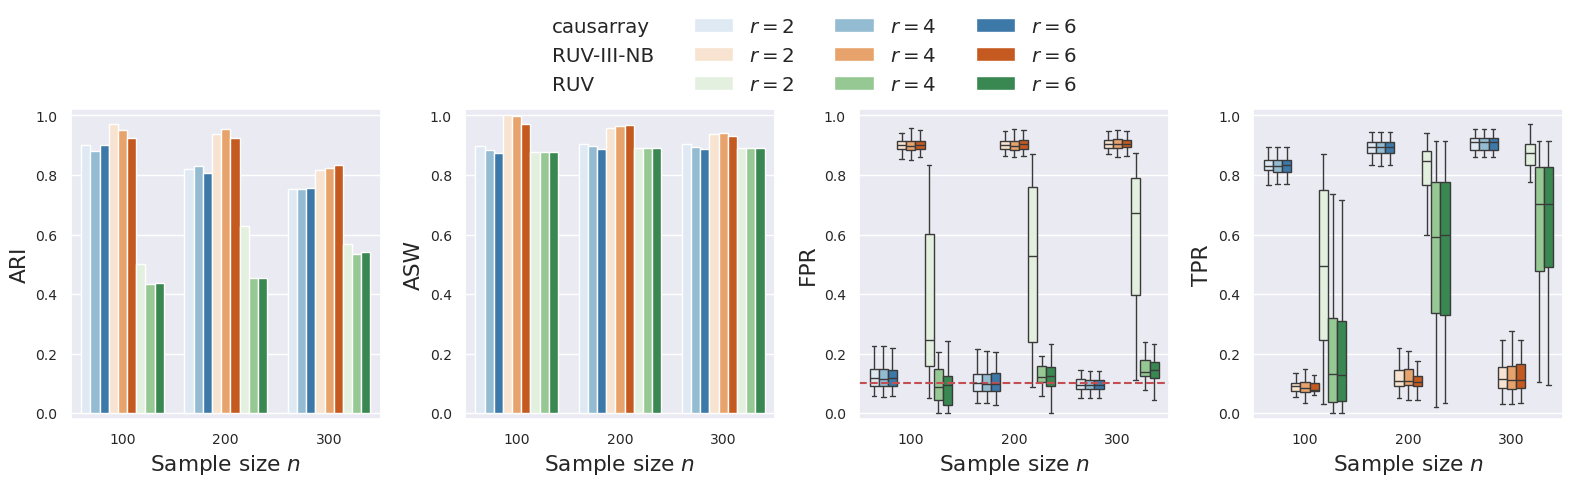

In [12]:
path_base = '/home/jinandmaya/simu_poi/'
ind = '_d_2_r_1_noise_0.5'

df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))

r_list = [2,4,6]
n_list = [100,200,300]
method_name = reduce(lambda a, b: dict(a, **b), 
    [{'causarray_r_{}'.format(r):'causarray $r={}$'.format(r) for r in r_list},
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB $r={}$'.format(r) for r in r_list}, 
      {'ruv_r_{}'.format(r):'RUV $r={}$'.format(r) for r in r_list}
    ])

zmax = df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().max().values
zmin = 0.*df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().min().values
df_cf[['ARI', 'ASW']] = (df_cf[['ARI', 'ASW']].values - zmin[None,:])/(zmax[None,:]-zmin[None,:])

df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]
df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)

df_test = df_test[df_test['n'].isin(n_list)]
df_cf = df_cf[df_cf['n'].isin(n_list)]

method_list = method_name.values()
palette = reduce(lambda l1, l2: l1+l2, [sns.color_palette(name)[:len(r_list)*2:2] for name in ['Blues', 'Oranges', 'Greens']])
hue_order = {i:c for i,c in zip(method_list, palette) }

sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,5), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):
    sns.barplot(data=df_cf, x='n', y=metric, hue='method', hue_order=hue_order,
        estimator='median', errorbar=None,
        ax=axes[j], palette=palette)

axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
handles = [mlines.Line2D([], [], linestyle='None')] * 3 + handles[::3] + handles[1::3] + handles[2::3]
labels = ['causarray', 'RUV-III-NB', 'RUV',
            '$r=2$', '$r=2$', '$r=2$',
            '$r=4$', '$r=4$', '$r=4$',
            '$r=6$', '$r=6$', '$r=6$',
            ]

for j in range(4):
    axes[j].set_ylim(-0.02,1.02)
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Sample size $n$')
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=4, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig(path_base + 'results/simu_poi_r{}.pdf'.format(ind), bbox_inches='tight', pad_inches=0, dpi=300)